In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import seaborn as sns

from dfpac import settings
from dfpac.evaluation.evaluate import get_scores, get_lobo_nadr, get_discovery_curves
from dfpac.evaluation.plots import plot_discovery_curves
from dfpac.evaluation.stats import get_fold_enrichment
from dfpac.utils.misc import shorten


sns.set_context("notebook")
sns.set_style(
    "whitegrid",
    {
        "axes.linewidth": 2,
        "axes.edgecolor": "black",
        "grid.linestyle": "--",
        "axes.xmargin": 0,
        "axes.ymargin": 0,
    },
)


def format_df(df: pd.DataFrame, benchmark=False, nadr=False) -> pd.DataFrame:
    df = df.replace({"pses": "PSEs", "descriptors": "Descriptors"})

    if "Pipeline" in df.columns:
        pipelines = ["PSEs"]
        if benchmark is False:
            pipelines.insert(0, "Descriptors")
        if nadr is True:
            pipelines.insert(0, "RV")
        pipelines = CategoricalDtype(pipelines, ordered=True)
        df.Pipeline = df.Pipeline.astype(pipelines)
        df = df.sort_values("Pipeline")

    if "Species" in df.columns:
        df.Species = df.Species.apply(shorten)

    if nadr is True:
        df = df.replace({"PSEs": "Likelihood-based", "RV": "RV-based"})

    return df


def evaluate_lobo():
    dfs = []
    for species in settings.SPECIES:
        dfs.append(get_scores(experiment="lobo", species=species))
    data = pd.concat(dfs, axis=0, ignore_index=True)
    return data


def evaluate_benchmark():
    return get_scores(experiment="benchmark", pipelines=["pses"])


def evaluate_nadr():
    dfs = []
    for species in settings.SPECIES:
        dfs.append(get_lobo_nadr(species=species))
    data = pd.concat(dfs, axis=0, ignore_index=True)
    return data


def evaluate_discovery_curves():
    dfs = []
    for species in settings.SPECIES:
        dfs.append(get_discovery_curves(species=species))
    data = pd.concat(dfs, axis=0, ignore_index=True)
    return data

# LOBO Evaluation (Table 2)

In [3]:
lobo_data = format_df(evaluate_lobo())
lobo_data.groupby(["Species", "Pipeline"], observed=True).agg(["mean", "std"]).round(3)

AUROC          AUPR           WF1         \
                                  mean    std   mean    std   mean    std   
Species             Pipeline                                                
A. pleuropneumoniae Descriptors  0.958  0.015  0.966  0.010  0.858  0.014   
                    PSEs         0.992  0.007  0.993  0.006  0.880  0.040   
C. jejuni           Descriptors  0.940  0.013  0.945  0.019  0.839  0.021   
                    PSEs         0.958  0.010  0.958  0.011  0.883  0.029   
C. muridarum        Descriptors  0.829  0.011  0.870  0.015  0.769  0.031   
                    PSEs         0.872  0.012  0.892  0.011  0.788  0.024   
E. coli             Descriptors  0.918  0.010  0.893  0.015  0.853  0.017   
                    PSEs         0.935  0.007  0.920  0.012  0.892  0.013   
M. tuberculosis     Descriptors  0.750  0.012  0.804  0.026  0.658  0.022   
                    PSEs         0.772  0.010  0.850  0.007  0.724  0.018   
N. meningitidis     Descriptors  0.790  0.012  0.828  0.012  0.681  0.028   
                    PSEs         0.832  0.015  0.866  0.035  0.777  0.010   
S. aureus           Descriptors  0.932  0.009  0.966  0.004  0.836  0.043   
                    PSEs         0.934  0.009  0.963  0.006  0.859  0.033   
S. pneumoniae       Descriptors  0.790  0.028  0.815  0.030  0.667  0.034   
                    PSEs         0.841  0.015  0.870  0.012  0.738  0.031   
S. pyogenes         Descriptors  0.840  0.013  0.878  0.009  0.795  0.013   
                    PSEs         0.812  0.012  0.808  0.017  0.791  0.025   
Y. pestis           Descriptors  0.801  0.048  0.813  0.046  0.758  0.046   
                    PSEs         0.805  0.017  0.718  0.010  0.790  0.029   

                                   MCC         
                                  mean    std  
Species             Pipeline                   
A. pleuropneumoniae Descriptors  0.734  0.036  
                    PSEs         0.784  0.065  
C. jejuni           Descriptors  0.685  0.040  
                    PSEs         0.768  0.055  
C. muridarum        Descriptors  0.566  0.062  
                    PSEs         0.611  0.043  
E. coli             Descriptors  0.708  0.034  
                    PSEs         0.783  0.025  
M. tuberculosis     Descriptors  0.424  0.028  
                    PSEs         0.468  0.029  
N. meningitidis     Descriptors  0.362  0.057  
                    PSEs         0.554  0.019  
S. aureus           Descriptors  0.667  0.086  
                    PSEs         0.713  0.066  
S. pneumoniae       Descriptors  0.341  0.069  
                    PSEs         0.510  0.061  
S. pyogenes         Descriptors  0.592  0.028  
                    PSEs         0.599  0.052  
Y. pestis           Descriptors  0.515  0.095  
                    PSEs         0.586  0.053

In [4]:
lobo_data.drop("Species", axis=1).groupby(["Pipeline"], observed=True).agg(["mean", "std"]).round(3)

AUROC          AUPR           WF1           MCC       
              mean    std   mean    std   mean    std   mean    std
Pipeline                                                           
Descriptors  0.855  0.074  0.878  0.064  0.771  0.080  0.559  0.149
PSEs         0.875  0.072  0.884  0.079  0.812  0.064  0.638  0.121

# Benchmark Evaluation (Table 3)

In [ ]:
benchmark_data = format_df(evaluate_benchmark(), benchmark=True)
benchmark_data.groupby(["Pipeline"], observed=True).agg(["mean", "std"]).round(2)

# Candidate antigen simulation (Table 4)

In [5]:
intmean = lambda x: int(x.mean()) + 1  # noqa
intmean.__name__ = "mean"
aggregations = {"nADR": ["mean"], "FHI": [intmean]}


nadr_data = format_df(evaluate_nadr(), nadr=True)
nadr_data.groupby(["Species", "Pipeline"], observed=True).agg(aggregations).round(3)

/tmp/ipykernel_451/852875828.py:42: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df = df.replace({"PSEs": "Likelihood-based", "RV": "RV-based"})


nADR  FHI
                                       mean mean
Species             Pipeline                    
A. pleuropneumoniae RV-based          0.472   41
                    Likelihood-based  0.739    2
C. jejuni           RV-based          0.589   15
                    Likelihood-based  0.846    3
C. muridarum        RV-based          0.565   10
                    Likelihood-based  0.884    3
E. coli             RV-based          0.547   22
                    Likelihood-based  0.754    4
M. tuberculosis     RV-based          0.504   38
                    Likelihood-based  0.825   12
N. meningitidis     RV-based          0.558   13
                    Likelihood-based  0.788    3
S. aureus           RV-based          0.554    8
                    Likelihood-based  0.709    2
S. pneumoniae       RV-based          0.497   18
                    Likelihood-based  0.790    2
S. pyogenes         RV-based          0.506    6
                    Likelihood-based  0.840    1
Y. pestis           RV-based          0.489  125
                    Likelihood-based  0.674   18

In [6]:
nadr_data.drop("Species", axis=1).groupby(["Pipeline"], observed=True).agg(aggregations).round(3)

,nADR,FHI
,mean,mean
Pipeline,,
RV-based,0.528,30
Likelihood-based,0.785,5


# Candidate antigen simulation evolution plot (Figure 5)

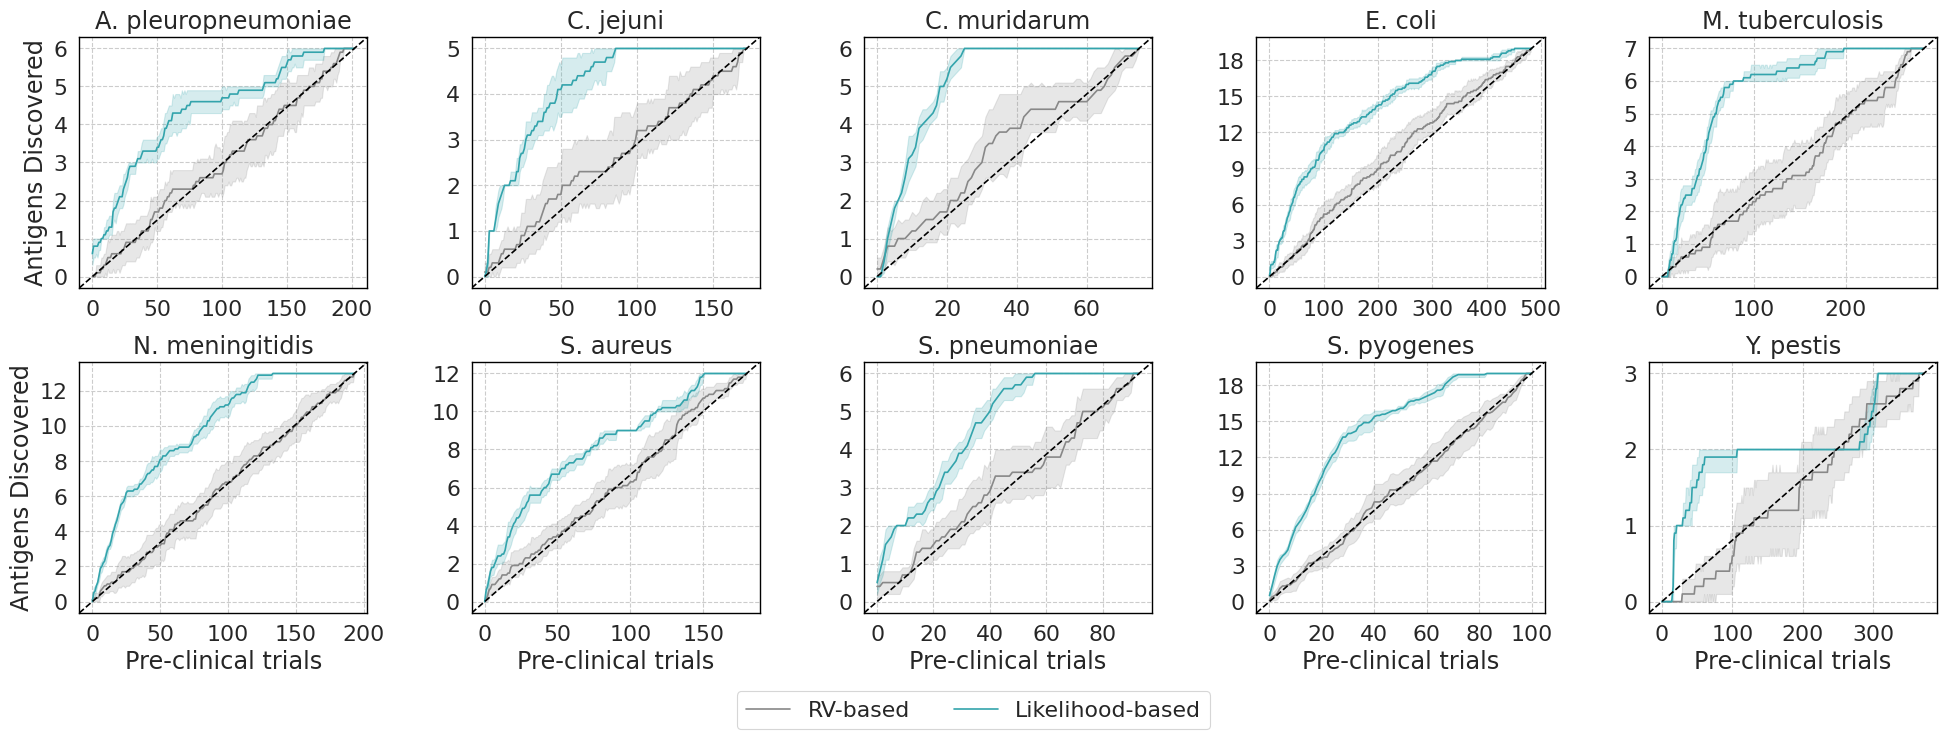

In [7]:
curves_data = format_df(evaluate_discovery_curves(), nadr=True)
with sns.plotting_context(context="paper", font_scale=1.8):
    plot_discovery_curves(curves_data, bottom=0.16)

# Fold enrichment analysis (Table 5)

In [9]:
get_fold_enrichment()

,Species,Size,90th Perc.,Exp.,Obs.,Fold Inc.,Recall,PVal.
0,Actinobacillus pleuropneumoniae,203,21,0.620690,2,3.222222,0.333333,0.015705
1,Campylobacter jejuni,173,18,0.520231,2,3.844444,0.400000,0.008391
2,Chlamydia muridarum,76,8,0.631579,2,3.166667,0.333333,0.013584
3,Escherichia coli,484,49,1.923554,7,3.639098,0.368421,0.000201
4,Mycobacterium tuberculosis,286,29,0.709790,3,4.226601,0.428571,0.002442
5,Neisseria meningitidis,194,20,1.340206,6,4.476923,0.461538,0.000049
6,Staphylococcus aureus,181,19,1.259669,4,3.175439,0.333333,0.003706
7,Streptococcus pneumoniae,94,10,0.638298,2,3.133333,0.333333,0.014968
8,Streptococcus pyogenes,101,11,2.069307,5,2.416268,0.263158,0.005256
9,Yersinia pestis,373,38,0.305630,1,3.271930,0.333333,0.028432
